In [70]:
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [71]:
training = pd.read_csv("./CongressionalVotingID.shuf.lrn.csv")

In [72]:
#preprocessing

#we drop the ID column which is not relevant
training.drop('ID', axis=1, inplace=True)

#we transform yes in 1 and no in 0, we convert "unknown" in NaN value and republican in 1 and democrat in 0, thus we have only binary values
training = training.applymap(lambda x : 1 if x == "y" else (0 if x == "n" else (np.nan if x == "unknown" else (1 if x == "republican" else 0))))
training.describe()

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,218.000000,211.000000,194.000000,209.000000,211.000000,212.000000,213.000000,211.000000,213.000000,209.000000,216.000000,206.000000,203.000000,206.000000,210.000000,199.000000,168.000000
mean,0.366972,0.459716,0.541237,0.598086,0.407583,0.504717,0.629108,0.559242,0.591549,0.511962,0.527778,0.398058,0.369458,0.529126,0.595238,0.437186,0.845238
std,0.483088,0.499560,0.499586,0.491462,0.492553,0.501161,0.484182,0.497659,0.492705,0.501057,0.500387,0.490690,0.483851,0.500367,0.492019,0.497290,0.362759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
#only rows with at least 15 known values
training.dropna(axis=0, thresh=15, subset=None, inplace=True)
#we transform unknown values in 1 or 0 randomly
training = training.fillna(random.randint(0,1))
training

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
1,1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,1,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
213,0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
214,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
215,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


In [74]:
training.describe()

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.365000,0.475000,0.565000,0.600000,0.410000,0.510000,0.620000,0.570000,0.585000,0.525000,0.530000,0.405000,0.400000,0.535000,0.595000,0.470000,0.875000
std,0.482638,0.500628,0.497001,0.491127,0.493068,0.501154,0.486604,0.496318,0.493958,0.500628,0.500352,0.492124,0.491127,0.500025,0.492124,0.500352,0.331549
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
test = pd.read_csv("./CongressionalVotingID.shuf.tes.csv")
#preprocessing
test.drop('ID', axis=1, inplace=True)
test = test.applymap(lambda x : 1 if x == "y" else (0 if x == "n" else (np.nan if x == "unknown" else (1 if x == "republican" else 0))))
test.dropna(axis=0, thresh=15, subset=None, inplace=True)
test = test.fillna(random.randint(0,1))
test.describe()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,0.361582,0.480226,0.559322,0.463277,0.531073,0.666667,0.548023,0.525424,0.485876,0.502825,0.327684,0.525424,0.531073,0.632768,0.395480,0.802260
std,0.481822,0.501026,0.497877,0.500064,0.500449,0.472742,0.499100,0.500770,0.501218,0.501410,0.470700,0.500770,0.500449,0.483418,0.490341,0.399425
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [76]:
training.head()

,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
1,1,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [77]:
training.info()
votes_count=training["class"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 217
Data columns (total 17 columns):
class                                     200 non-null int64
handicapped-infants                       200 non-null float64
water-project-cost-sharing                200 non-null float64
adoption-of-the-budget-resolution         200 non-null float64
physician-fee-freeze                      200 non-null float64
el-salvador-aid                           200 non-null float64
religious-groups-in-schools               200 non-null float64
anti-satellite-test-ban                   200 non-null float64
aid-to-nicaraguan-contras                 200 non-null float64
mx-missile                                200 non-null float64
immigration                               200 non-null float64
synfuels-crporation-cutback               200 non-null float64
education-spending                        200 non-null float64
superfund-right-to-sue                    200 non-null float64
crime          

[Text(0, 0, 'democrat'), Text(0, 0, 'republican')]

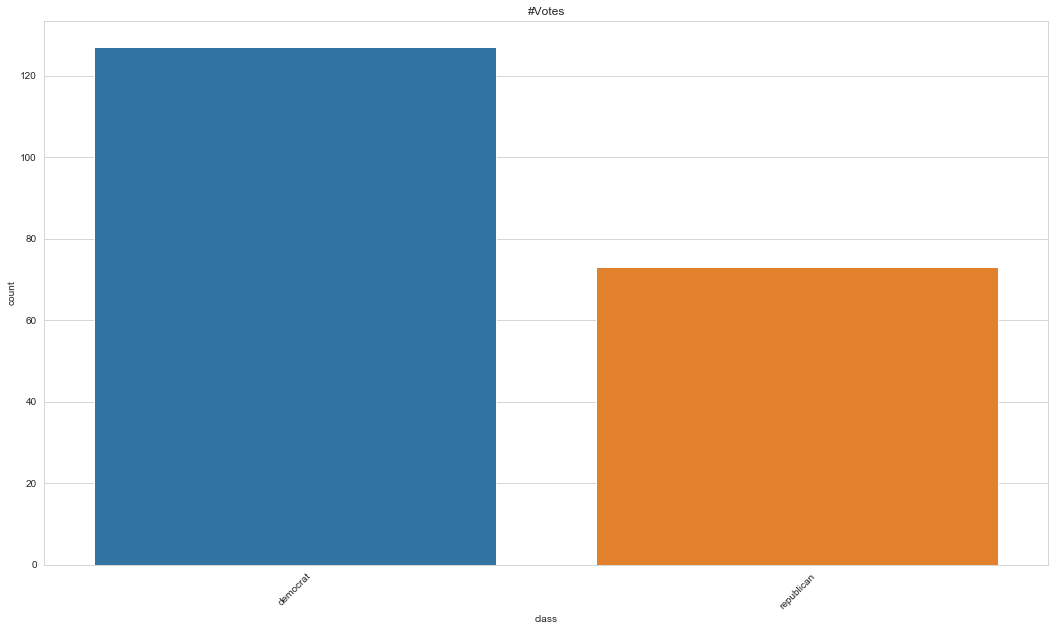

In [78]:
countplt, ax = plt.subplots(figsize = (18,10))
ax = sns.countplot(data=training, x='class')
ax.set_title("#Votes")
ax.set_xticklabels(["democrat","republican"], rotation=45)

In [79]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(training, test_size=0.2, random_state=42)
train = np.array(train_set)[:,1:]
train_target = np.array(train_set)[:,0]
test = np.array(test_set)[:,1:]
test_target = np.array(test_set)[:,0]

In [109]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , balanced_accuracy_score , precision_score , recall_score , brier_score_loss
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import seaborn as sns
sns.set_style('whitegrid')

### Variables for performance analysis ###

# abstract table
abstract = []

    # For classifiers
    
# the dataset is a bit imbalanced and our accuracy should be balanced
balance = True
# we don't have any distinction between false positive and false negative, so precision is irrelevant
precision = False
recall = False
macro = True
# the dataset has a binary target (mutually exclusive) so we can use the Brier score
brier = True

    # For regression

# the dataset is a classifier
MSE = False
variance = False
# poisson ? gamma ? percentage ?

def create_knn(train_data, target, n_neighbors=1):
    clf = KNeighborsClassifier(n_neighbors = n_neighbors)
    clf.fit(train_data, target )
    return clf

def create_perceptron(train_data, target, eta=0.1, n_iter=50, random_state=42):
    clf = Perceptron(random_state=random_state, 
                     eta0=eta)
    clf.fit(train_data, target)
    return clf

def create_decisiontree(train_data, target, random_state=42, max_leaf_nodes=10):
    clf = DecisionTreeClassifier(random_state=0,max_leaf_nodes=max_leaf_nodes)
    clf.fit(train_data, target)
    return clf

def create_rnd_forrest(train_data, target, random_state=42, max_leaf_nodes=10):
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(train_data, target)
    return clf

def create_nb(train_data, target):
    clf =MultinomialNB()
    clf.fit(train_data , target)
    return clf
    
def evaluate_algo(algo, test_data, test_target, train_data, train_target):
    abstract.append([algo])
    print(algo)
    pred_test  = algo.predict(test_data)
    pred_train = algo.predict(train_data)
    if (balance) :
        n1 = 100*balanced_accuracy_score(test_target, pred_test)
        n2 = 100*balanced_accuracy_score(train_target, pred_train)
        abstract[-1].append(["balanced accuracy",n1,n2])
        print("balanced accuracy of testset is {:.5} %".format(n1))
        print("balanced accuracy of trainset is {:.5} %".format(n2))
    else :
        n1 = 100*balanced_accuracy_score(test_target, pred_test)
        n2 = 100*balanced_accuracy_score(train_target, pred_train)
        abstract[-1].append(["accuracy",n1,n2])
        print("accuracy of testset is {:.5} %".format(n1))
        print("accuracy of trainset is {:.5} %".format(n2))
    if (macro) :
        if (precision) :
            n1 = 100*precision_score(test_target, pred_test, average="macro")
            n2 = 100*precision_score(train_target, pred_train, average="macro")
            abstract[-1].append(["precision",n1,n2])
            print("precision of testset is {:.5} %".format(n1))
            print("precision of trainset is {:.5} %".format(n2))
        if (recall) :
            n1 = 100*recall_score(test_target, pred_test, average="macro")
            n2 = 100*recall_score(train_target, pred_train, average="macro")
            abstract[-1].append(["recall",n1,n2])
            print("recall of testset is {:.5} %".format(n1))
            print("recall of trainset is {:.5} %".format(n2))
    else :
        if (precision) :
            n1 = 100*precision_score(test_target, pred_test, average="micro")
            n2 = 100*precision_score(train_target, pred_train, average="micro")
            abstract[-1].append(["precision",n1,n2])
            print("precision of testset is {:.5} %".format(n1))
            print("precision of trainset is {:.5} %".format(n2))
        if (recall) :
            n1 = 100*recall_score(test_target, pred_test, average="micro")
            n2 = 100*recall_score(train_target, pred_train, average="micro")
            abstract[-1].append(["recall",n1,n2])
            print("recall of testset is {:.5} %".format(n1))
            print("recall of trainset is {:.5} %".format(n2))
    if (hasattr(algo, "predict_proba") and (brier)) :
        proba_test  = algo.predict_proba(test_data)[:,1]
        proba_train = algo.predict_proba(train_data)[:,1]
        n1 = 100*brier_score_loss(test_target, proba_test)
        n2 = 100*brier_score_loss(train_target, proba_train)
        abstract[-1].append(["brier",n1,n2])
        print("brier of testset is {:.5} %".format(n1))
        print("brier of trainset is {:.5} %".format(n2))
    cmat = confusion_matrix(test_target, pred_test)
    plt.figure(figsize = (6, 6))
    sns.heatmap(cmat, annot = True, 
                cmap = 'Paired', 
                cbar = False, 
                fmt="d", 
                xticklabels=['Democrat', 'Republican'], 
                yticklabels=['Democrat', 'Republican']);

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
balanced accuracy of testset is 81.868 %
balanced accuracy of trainset is 94.915 %
brier of testset is 10.625 %
brier of trainset is 2.1875 %
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
balanced accuracy of testset is 87.088 %
balanced accuracy of trainset is 93.145 %
brier of testset is 10.556 %
brier of trainset is 3.4722 %
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')
balanced accuracy of testset is 83.516 %
balanced accuracy of trainset is 93.145 %
brier of testset is 8.75 %
brier of trainset is 4.2578 %
KNeighborsClass

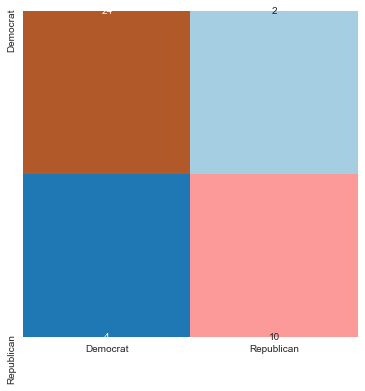

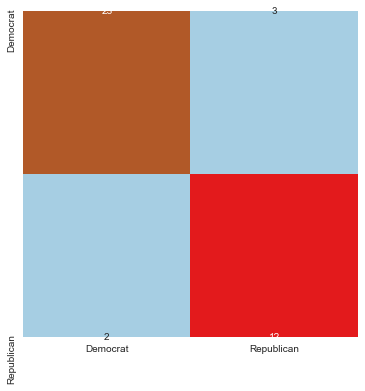

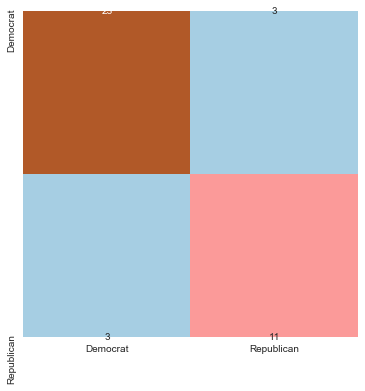

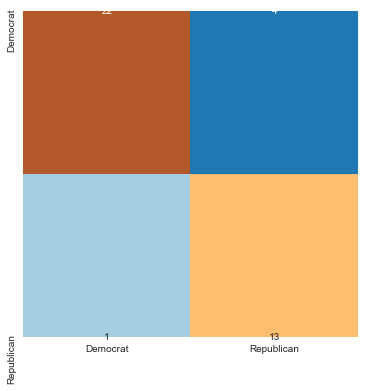

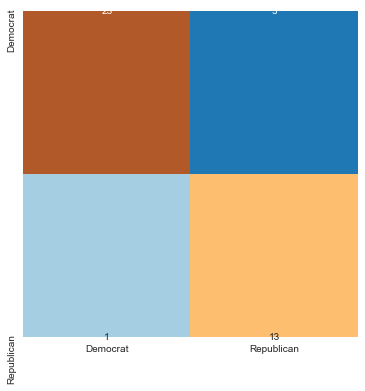

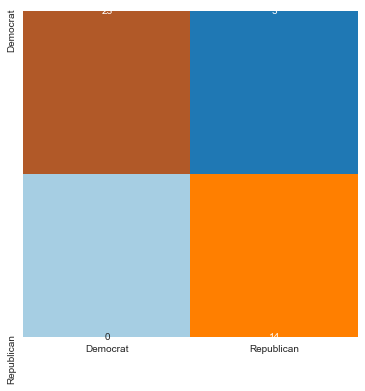

In [110]:
N_NEIGHBORS = [2,3,4,5,6,7] #4 is the best
for n_neighbors in N_NEIGHBORS :
    knn = create_knn(train, train_target, n_neighbors)
    evaluate_algo(knn, test, test_target, train, train_target)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
balanced accuracy of testset is 100.0 %
balanced accuracy of trainset is 96.04 %
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.5,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
balanced accuracy of testset is 89.286 %
balanced accuracy of trainset is 97.667 %
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbos

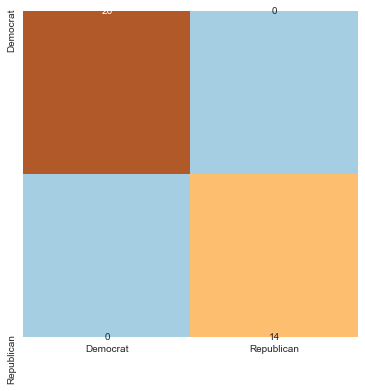

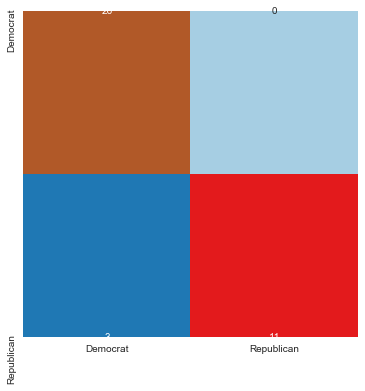

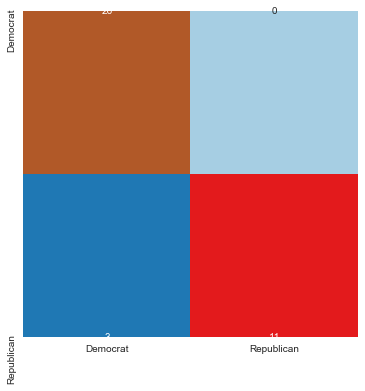

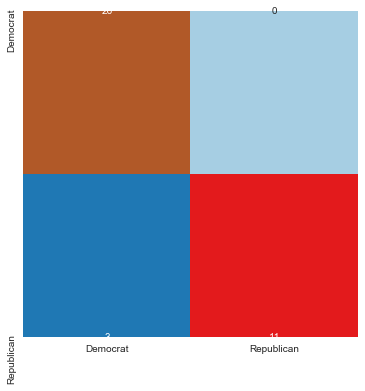

In [111]:
N_ITER = [50]
ETA = [0.1,0.5,1,2] #0.5 and higher are better
for eta in ETA :
    for n_iter in N_ITER :
        ppn = create_perceptron(train, train_target, eta,
                        n_iter, random_state=42)
        evaluate_algo(ppn, test, test_target, train, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
balanced accuracy of testset is 89.286 %
balanced accuracy of trainset is 99.153 %
brier of testset is 5.625 %
brier of trainset is 0.3125 %


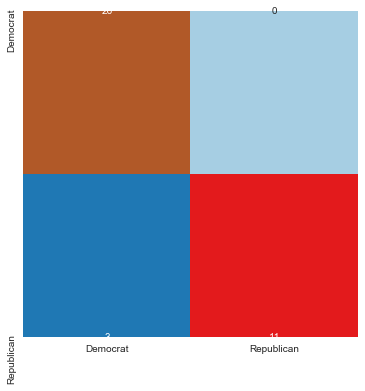

In [112]:
dtree = create_decisiontree(train, train_target,
                            random_state=42, max_leaf_nodes=100)
evaluate_algo(dtree, test, test_target, train, train_target)

C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
balanced accuracy of testset is 98.077 %
balanced accuracy of trainset is 93.64 %
brier of testset is 4.823 %
brier of trainset is 5.469 %
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
              

C:\Users\saeny\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
balanced accuracy of testset is 98.077 %
balanced accuracy of trainset is 93.64 %
brier of testset is 4.823 %
brier of trainset is 5.469 %


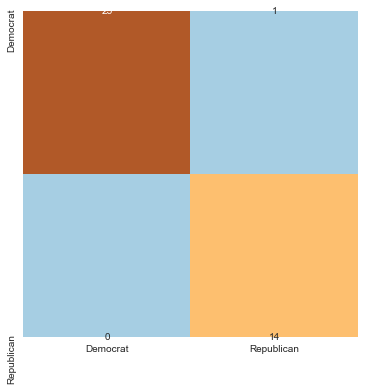

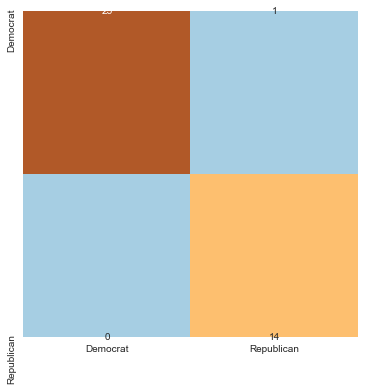

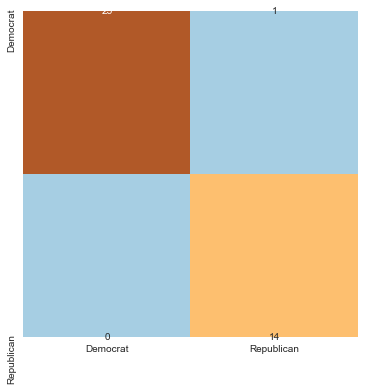

In [113]:
MAX_LEAF = [50,100,200] # does not change anything
for max_leaf_nodes in MAX_LEAF :
    rndf = create_rnd_forrest(train, train_target,
                                random_state=42, max_leaf_nodes=100)
    evaluate_algo(rndf, test, test_target, train, train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
balanced accuracy of testset is 88.736 %
balanced accuracy of trainset is 89.822 %
brier of testset is 9.3014 %
brier of trainset is 7.9398 %


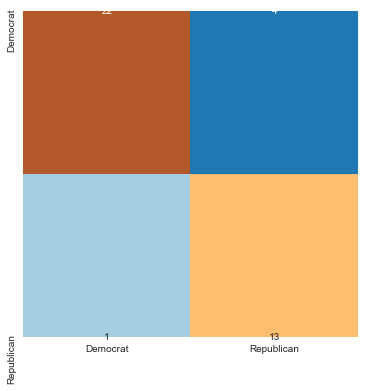

In [114]:
nb = create_nb(train, train_target)
evaluate_algo(nb, test, test_target, train, train_target)

In [119]:
for row in abstract :
    print(row[0])
    for e in row[1:] :
        print(e[0] + " : " + str(e[1]) + " " + str(e[2]))
    print("\n")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
balanced accuracy : 81.86813186813187 94.91525423728814
brier : 10.625 2.1875


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
balanced accuracy : 87.08791208791209 93.14482295687196
brier : 10.555555555555555 3.472222222222223


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')
balanced accuracy : 83.5164835164835 93.14482295687196
brier : 8.75 4.2578125


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights=